**Goal**<br>
The goal of this excercise is to adversarially attack the ResNet152 model, trained on ImageNet, using the projected gradient descent (PGD) algorithm presented in class.


<br>

**Task 1**<br>
Implement the PGD algorithm in the pgd_attack function.

Hints:
- Use the PyTorch functions torch.sign() and torch.clamp()
- You can access the gradient of a tensor as follows: adversarial_image.grad

<br>

**Task 2**<br>
Implement the call to the pgd_attack function".

<br>

**Task 3 **<br>
Implement code that would predict the class of the adversarial image.

<br>

In [2]:
import json
import urllib.request

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torchvision import models

device = 'cuda'

In [3]:
# convert numbers in [0,999] to class names in ImageNet
with urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json') as url:
    data = json.loads(url.read().decode())

def class_name(class_idx):
    return data[str(class_idx)][1]

In [4]:
# download image from internet
urllib.request.urlretrieve(
    'https://i.guim.co.uk/img/media/fe1e34da640c5c56ed16f76ce6f994fa9343d09d/0_174_3408_2046/master/3408.jpg?width=1200&height=900&quality=85&auto=format&fit=crop&s=0d3f33fb6aa6e0154b7713a00454c83d',
    'image.jpg')

# read image
image = Image.open('image.jpg')

# transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

image = transform(image).to(device)

In [5]:
# module that subtracts mean and divides by standard deviation (for each RGB channel)
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

# download ResNet152 pretrained on ImageNet
resnet152 = models.resnet152(pretrained=True)

# concate normalization and ResNet18
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    resnet152
).to(device)

model.eval()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


Sequential(
  (0): Normalize()
  (1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

In [6]:
def pgd_attack(model, image, label, eps=0.3, alpha=2/255, iters=40):
    loss_function = nn.CrossEntropyLoss()

    image = image.unsqueeze(0)
    image, label = image.to(device), label.to(device)

    adversarial_image = image.clone()
    for i in range(iters):
        adversarial_image.requires_grad = True

        # forward pass
        logits = model(adversarial_image)

        # backward pass
        model.zero_grad()
        loss_function(logits, label).backward()

        # ADD CODE HERE -------------------------------------------

        adversarial_image.data = (adversarial_image + alpha*adversarial_image.grad.detach().sign()).clamp(-eps, eps)
        adversarial_image.grad.zero_()
        
        adversarial_image.detach_()
        
    return adversarial_image.squeeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


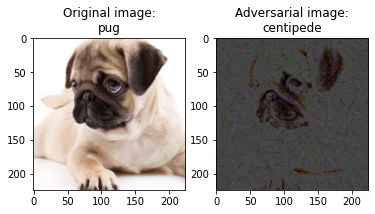

In [7]:
# prediction on original image
logits = model(image.unsqueeze(0)) # dimension of input: 1 3 299 299
_, idx_pred_orig_img = torch.max(logits, 1)
class_name_pred_orig_img = class_name(idx_pred_orig_img.item())

# create adversarial image
label = torch.LongTensor([idx_pred_orig_img])
# ADD CODE HERE
adversarial_image = pgd_attack(model, image, label)

# prediction on adversarial image
# ADD CODE HERE
logits2 = model(adversarial_image.unsqueeze(0)) # dimension of input: 1 3 299 299
_, idx_pred_adv_img = torch.max(logits2, 1)
class_name_pred_adv_img = class_name(idx_pred_adv_img.item())

# show results
fig, axarr = plt.subplots(1,2)
axarr[0].imshow(np.transpose(image.cpu().numpy(),(1,2,0)))
axarr[0].set_title('Original image:\n'+class_name_pred_orig_img)
axarr[1].imshow(np.transpose(adversarial_image.cpu().numpy(),(1,2,0)))
axarr[1].set_title('Adversarial image:\n'+class_name_pred_adv_img)
plt.show()